# Проект 4: классификация

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import GridSearchCV
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFE

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [7]:
# Ссылка на датасет
url_data = 'https://lms-cdn.skillfactory.ru/assets/courseware/v1/dab91dc74eb3cb684755123d224d262b/asset-v1:\
SkillFactory+DSPR-2.0+14JULY2021+type@asset+block/bank_fin.zip'

# Загружаем и проверяем данные
df = pd.read_csv(url_data, sep = ';', compression='zip')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [8]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
display(df.info())

# пропуски присутствуют в признаке balance, выведем их количество
print(f"Количество пропусков в признаке balance: {df['balance'].isna().sum()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


None

Количество пропусков в признаке balance: 25


### Задание 2

In [9]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
# Посмотрим на все значения в данном признаке
print(df['job'].value_counts(), '\n')
print(f"Пропуски в признаке job обозначены словом: {df['job'].value_counts().index[-1]}")

job
management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: count, dtype: int64 

Пропуски в признаке job обозначены словом: unknown


### Задание 3

In [10]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
# Заменяем запятую на точку, убираем пробелы и знак доллара, преобразовываем в тип float
df['balance'] = df[~df['balance'].isna()]['balance'].apply(lambda x: str(x).replace(',', '.') if ~(x is np.NaN) else x)
df['balance'] = df[~df['balance'].isna()]['balance'].apply(lambda x: str(x).replace(' ', '') if ~(x is np.NaN) else x)
df['balance'] = df[~df['balance'].isna()]['balance'].apply(lambda x: float(x[:-1]))
print(f"Среднее значение признака balance: {round(df['balance'].mean(), 3)}")

Среднее значение признака balance: 1529.129


### Задание 4

In [11]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
df['balance'].fillna(df['balance'].median(), inplace=True)
print(f"Среднее значение признака balance после обработки пропусков: {round(df['balance'].mean(), 3)}")

Среднее значение признака balance после обработки пропусков: 1526.936


### Задание 5

In [12]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
mask = (df['job'] == df['job'].value_counts().index[-1])
df.loc[mask, 'job'] = df['job'].mode()[0]

mask = (df['education'] == 'unknown')
df.loc[mask, 'education'] = df['education'].mode()[0]

# рассчитываем среднее значение баланса для клиентов с самым популярным видом образования и работой
mask = ((df['job'] == df['job'].mode()[0]) & (df['education'] == df['education'].mode()[0]))
print(f"Среднее значение признака balance после обработки пропусков в признаках образование и работа: {round(df[mask]['balance'].mean(), 3)}")



Среднее значение признака balance после обработки пропусков в признаках образование и работа: 1598.883


### Задание 6

In [13]:
# удалите все выбросы для признака balance
# Зададим функцию для поиска выбросов по методу Тьюки
    
def outliers_iqr_mod(data, feature, left=1.5, right=1.5):
    """Функция для поиска выбросов по методу Тьюки

    Args:
        data (dataframe): Исходный датафрейм
        feature (string): наименование признака в котором ищем выбросы
        left (float, optional): коэффициент межквартильного размаха для нижней границы поиска выбросов по методу Тьюки. Defaults to 1.5.
        right (float, optional): коэффициент межквартильного размаха для верхней границы поиска выбросов по методу Тьюки. Defaults to 1.5.

    Returns:
        dataframe, float: датафрейм с потенциальными выбросами, очищенный датафрейм, значения нижней и верхней границ поиска выбросов по методу Тьюки
    """
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr*left)
    upper_bound = quartile_3 + (iqr*right)
    outliers = data[(x <= lower_bound) | (x >= upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned, lower_bound, upper_bound

outliers, cleaned, lower_bound, upper_bound = outliers_iqr_mod(df, 'balance')

print(f'Нижняя граница поиска выбросов по методу Тьюки: {round(lower_bound)}')
print(f'Верхняя граница поиска выбросов по методу Тьюки: {round(upper_bound)}')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Нижняя граница поиска выбросов по методу Тьюки: -2241
Верхняя граница поиска выбросов по методу Тьюки: 4063
Число выбросов по методу Тьюки: 1058
Результирующее число записей: 10105


## Часть 2:  Разведывательный анализ

### Задание 1

deposit
no     0.54
yes    0.46
Name: proportion, dtype: float64

Количество клиентов открывших депозит: 4681


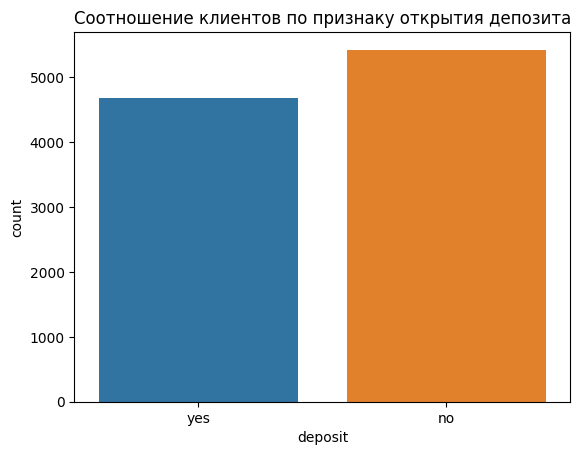

In [14]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
# Выведем процентное соотношение классов в признаке deposit
display(round(cleaned['deposit'].value_counts(normalize=True), 2))

# Построим диаграмму соотношения классов в признаке deposit
fig = sns.countplot(data=cleaned, x='deposit')
fig.set_title('Соотношение клиентов по признаку открытия депозита')

print(f"Количество клиентов открывших депозит: {cleaned[cleaned['deposit'] == 'yes']['deposit'].count()}")

### Задания 2 и 3

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


Максимальный возраст клиента банка: 95 лет
Минимальная продолжительность разговора с клиентом банка: 2 секунды


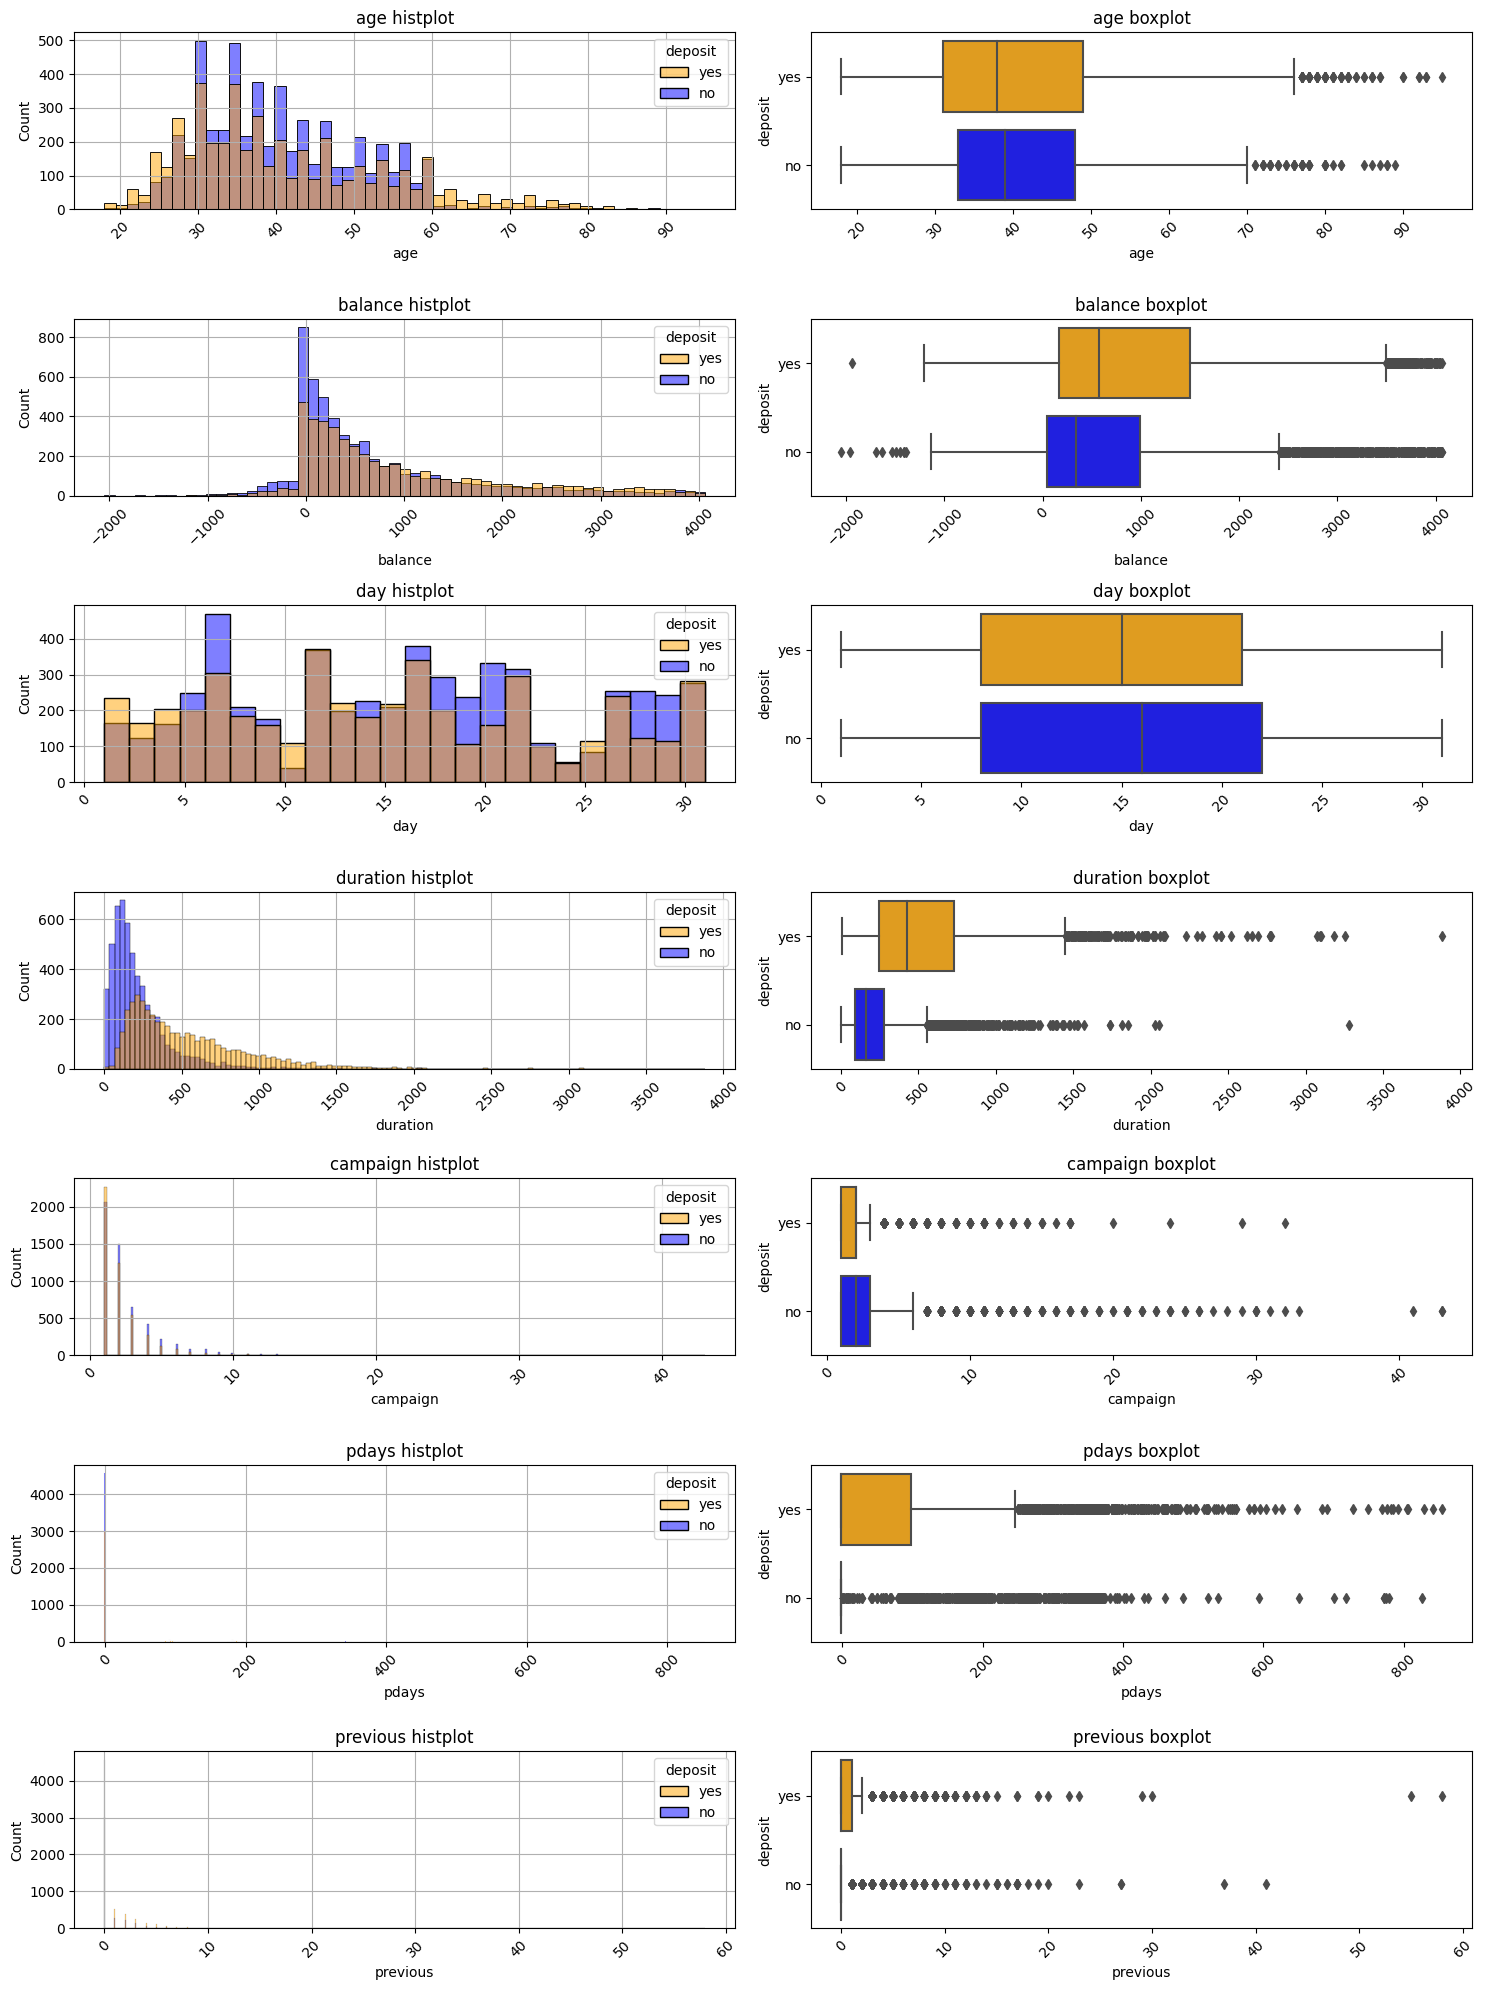

In [15]:
# рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
display(cleaned.describe())

#выделяем имена числовых признаков в виде списка для удобства дальнейшей работы
types = cleaned.dtypes
num_features = list(types[(types != 'object')].index)

# Для каждого числового признака построим гистограмму признаки и диаграмму размаха, 
# иллюстрирующую зависимость целевого признака от каждого из факторов. 
n = len(num_features) #количество числовых признаков
fig, axes = plt.subplots(n, 2, figsize=(15, 20)) # фигура + n х 2 координатных плоскостей

#Создаем цикл для всех признаков из списка числовых признаков
for i, feature in enumerate(num_features): #i- индекс, feature - название признака в таблице
    #Строим гистограмму распределения признака 
    histplot = sns.histplot(data=cleaned, x=feature, hue='deposit', palette=['orange', 'blue'], ax=axes[i][0])
    #Добавляем подпись графику
    histplot.set_title('{} histplot'.format(feature))
    # Доьавляем сетку
    histplot.grid()
    #Добавляем поворот отметок на оси абсцисс
    histplot.xaxis.set_tick_params(rotation=45)
    #Строим диаграмму размаха
    boxplot = sns.boxplot(data=cleaned, x=feature, y='deposit', palette=['orange', 'blue'], ax=axes[i][1])
    #Добавляем подпись графику
    boxplot.set_title('{} boxplot'.format(feature));
    #Добавляем поворот отметок на оси абсцисс
    boxplot.xaxis.set_tick_params(rotation=45)
plt.tight_layout() #выравнивание графиков

print(f"Максимальный возраст клиента банка: {cleaned['age'].max()} лет")
print(f"Минимальная продолжительность разговора с клиентом банка: {cleaned['duration'].min()} секунды")

### *Выводы*
+ Возраст клиентов (признак Age) находится в диапазоне от 18 до 95 лет. Стандартное отклонение составляет около 12 это значит, что основная часть клиентов имеет возраст от 29 до 53 лет. Средний возраст клиента составляет 41 год, однако медианное значение - 38 лет, что говорит о наличии аномальных значений с большей стороны. Это можно увидеть на диаграмме размаха. Судя по гистограмме клиенты младше 30 и старше 60 лет более склонны к открытию депозита. Данный признак единственный из числовых распределение которого напоминает нормельное.

+ Баланс клиентов (признак Balance) находится в диапазоне от минус 2049 до 4063 долларов. Стандартное отклонение составляет около 994 долларов это значит, что основная часть клиентов имеет на счету сумму в диапазоне от минус 186 до 1802 доллара. Средний баланс счета клиента составляет 808 долларов, однако медианное значение 445 доллларов, что говорит о наличии большого колличества аномальных значений с большей стороны. Учитывая, что минимальное значение и максимальное значения значительно отличаются от 25 и 75 процентиля можно сделать вывод о наличии аномальных значений и с меньшей и с большей стороны. Это можно увидеть на диаграмме размаха. Судя по гистограмме клиенты с балансом счета меньше 1000 долларов менее склонны к открытию депозита. Распределение данного признака больше напоминает логнормельное.

+ Признак day (день, в который был последний контакт) изменяется от 1 до 31. Судя по всему это день месяца. Стандартное отклонение составляет около 8 это значит, что с основной частью клиентов связывались с 8 по 24 число месяца. Среднее и медианное значения примерно равны, что говорит об отсутствии аномальных значений, что подтверждается диаграммой размаха. Судя по гистограмме распределение признака нельзя отнести к нормальному имеются несколько пиков и минимумов. 
Можно отметить, что во второй половине месяца клиенты менее склонны к открытию депозита.

+ Признак duration (продолжительность контакта в секундах) находится в диапазоне от 1 до 3881 секунды. Стандартное отклонение составляет около 347 секунд это значит, что контакт с основной частью клиентов длился от 22 до 716 секунд. Среднее время контакта с клиентом составляет 369 секунд, при этом медианное значение - 252 секунды, что говорит о наличии аномальных значений с большей стороны. Это можно увидеть на диаграмме размаха. Странно выглядит наличие большого числа аномальных значений для группы клиентов не открывших депозит - то есть клиент готов был на контакт но его что-то не устроило возможно дело в прдлагаемых условиях или проблемах в взаимодействии с клиентами. Судя по гистограмме длительность контакта с клиентом напрямую влияет на открытие ими депозита. При длительности контакта более 400 секунд клиенты значительно чаще открывали депозит. Распределение признака напоминает логнормальное.

+ Признак campaign (количество контактов с этим клиентом в течение текущей кампании) находится в диапазоне от 1 до 43. Стандартное отклонение составляет около 3 это значит, что количество контактов с большинством клиентов варьировалось от 0 до 6. Среднее значение признака превышает медиану, что говорит о наличии выбросов с большей стороны. Это видно на диаграмме размаха. Судя по гистограмме с ростом числа контактов падает количество клиентов открывших депозит. Распределение данного признака напоминает логнормельное.

+ Признак pdays (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании) находится в диапазоне от минус 1 до 854 дней. Стандартное отклонение составляет около 110 дней в тоже время 25 и 75 процентили имеют значения минус 1 и 2 соответственно. Кроме того среднее значение значительно превышает медиану все это говорит о болшом количестве аномальных значений с большей стороны. Это видно на диаграмме размаха. Судя по гистограмме с большинством клиентов банк контактировал по поводу предыдущих кампаний уже озвучив предложения текущей кампании. Распределение данного признака напоминает логнормельное.

+ Признак previous (количество контактов до текущей кампании) находится в диапазоне от 0 до 58. Стандартное отклонение составляет около 2 это значит, что количество контактов с большинством клиентов до текущей кампании составляло от 0 до 3 раз.  Среднее значение признака превышает медиану, что говорит о наличии выбросов с большей стороны. Это видно на диаграмме размаха. Распределение данного признака напоминает логнормельное. По диаграммам можно сделать вывод, что клиенты с которыми был контакт до текущей кампании более склонны к открытию депозита.


### Задания 4 и 5

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


Количество месяцев в которые проводилась маркетинговая кампания: 12
Количество сфер занятости среди клиентов банка: 11


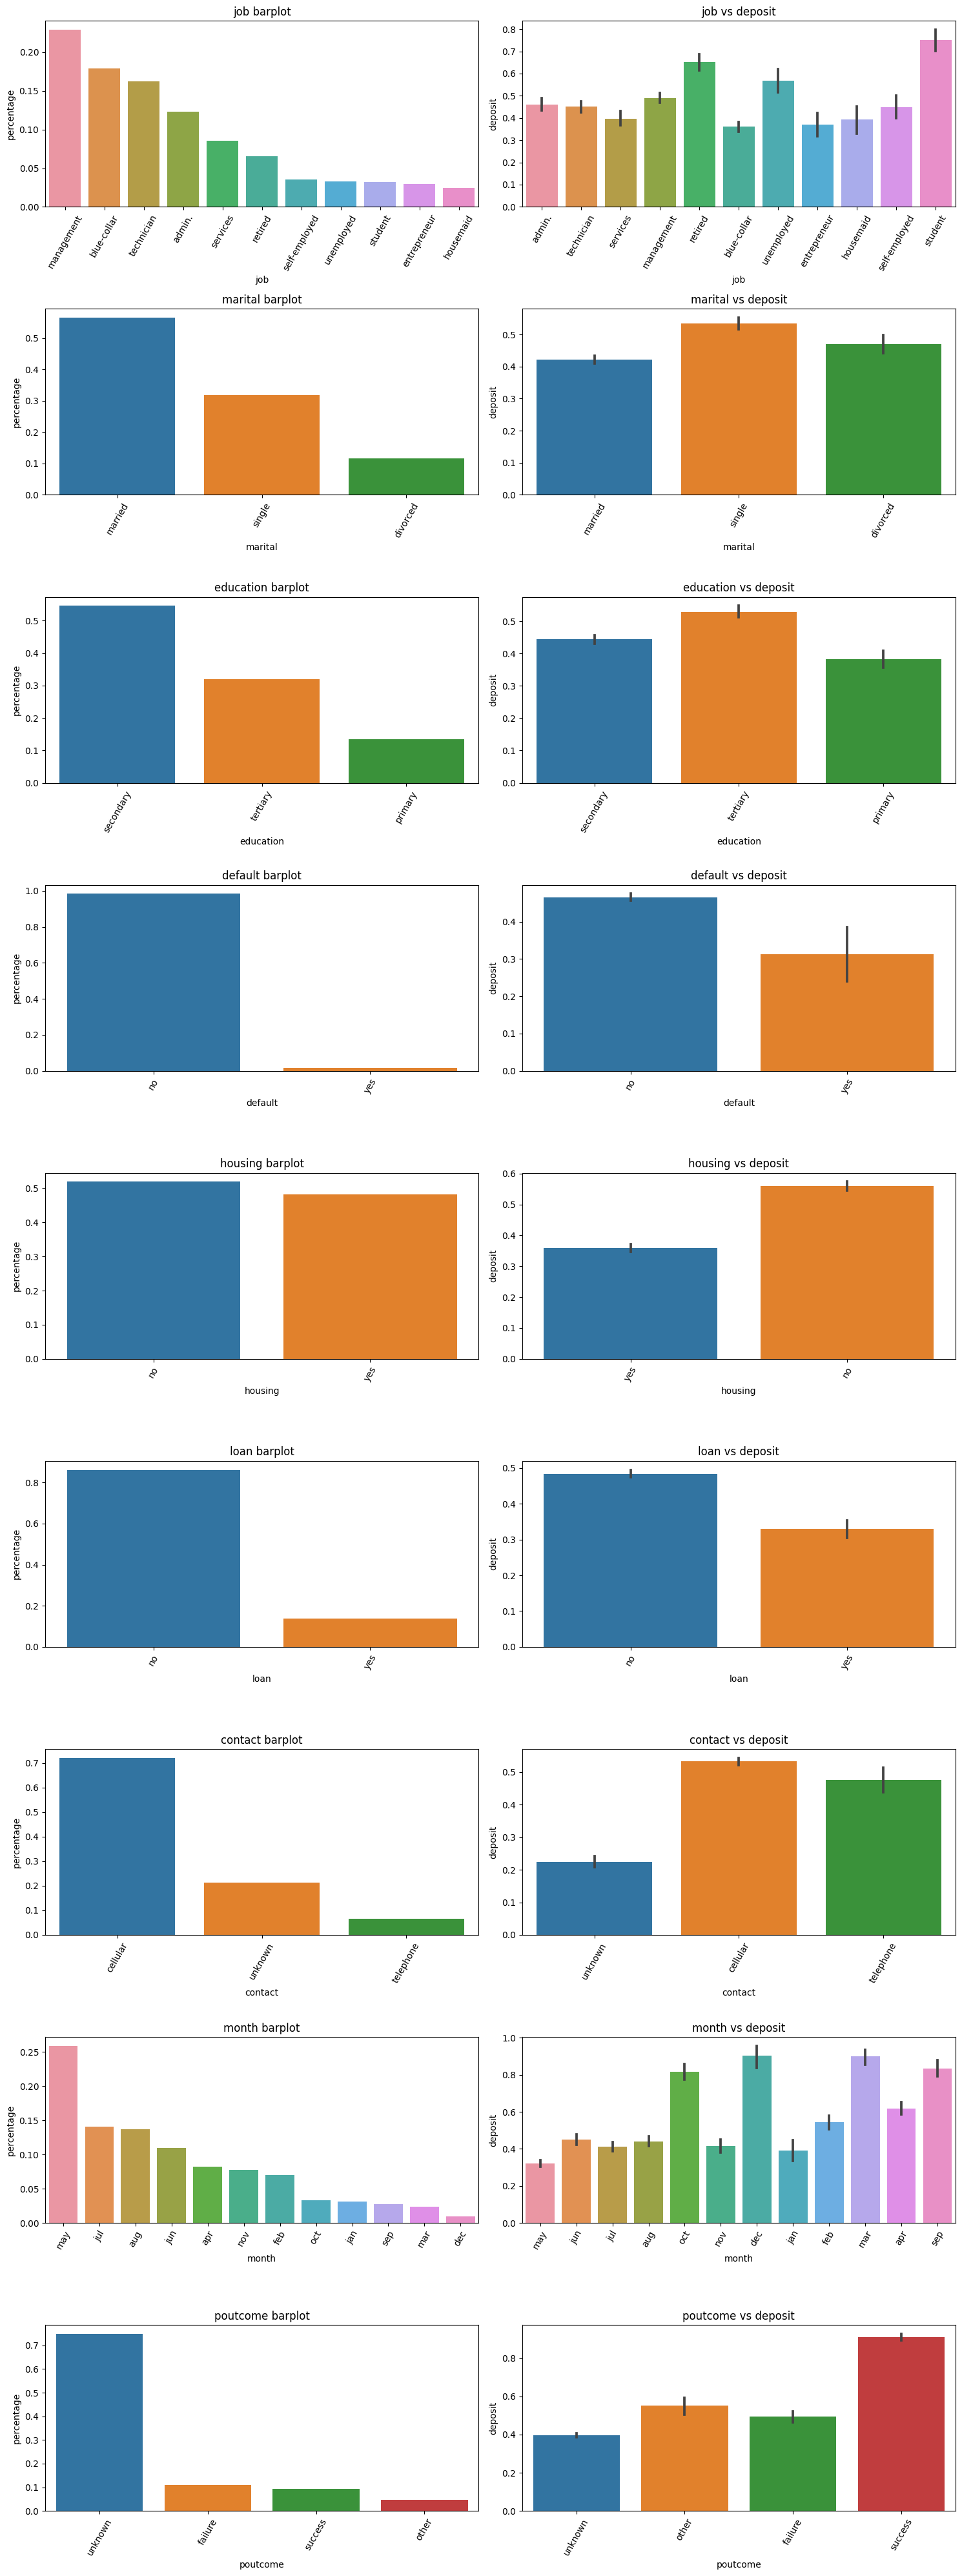

In [16]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
display(cleaned.describe(include='object'))

#постройте визуализации, иллюстрирующие результаты
#выделяем имена категориальных признаков в виде списка для удобства дальнейшей работы
types = cleaned.dtypes
cat_features = list(types[(types == 'object')].index)

# Уберем целевой признак из списка
cat_features = cat_features[:-1]

# Заменим значения целевого признака на числовые для построения визуализации
data = cleaned.copy()
data['deposit'] = data['deposit'].apply(lambda x: 1 if x == 'yes' else 0)


n = len(cat_features) # число категориальных признаков
fig, axes = plt.subplots(n, 2, figsize=(15, 40)) # фигура+n*2 координатных плоскостей

# Создаём цикл для всех признаков из списка категориальных признаков
for i, feature in enumerate(cat_features):
    # Строим количественную столбчатую диаграмму для долевого соотношения каждой из категорий в данных
    count_data = (cleaned[feature].value_counts(normalize=True)
                  .sort_values(ascending=False)
                  .rename('percentage')
                  .reset_index())
    count_barplot = sns.barplot(data=count_data, x=feature, y='percentage', ax=axes[i][0])
    count_barplot.set_title('{} barplot'.format(feature));
    count_barplot.xaxis.set_tick_params(rotation=60)
    
    # Строим столбчатую диаграмму доли людей открывших депозит (среднее по столбцу deposit) в зависимости от категории
    mean_barplot = sns.barplot(data=data, x=feature, y='deposit', ax=axes[i][1])
    mean_barplot.set_title('{} vs deposit'.format(feature));
    mean_barplot.xaxis.set_tick_params(rotation=60)    
plt.tight_layout() # выравнивание графиков

print(f"Количество месяцев в которые проводилась маркетинговая кампания: {cleaned['month'].nunique()}")
print(f"Количество сфер занятости среди клиентов банка: {cleaned['job'].nunique()}")

### *Выводы*

+ Признак job (сфера занятости) представлен 11 значениями. Наиболее популярная среди клиентов сфера занятости - менджмент, наименее популярная - горничные. Наибольшую склонность к открытию депозита проявляют - студенты, пенсионеры и безработных.

+ Признак marital (семейное положение) представлен 3 группами - семейные, одинокие и разведенные. Большинство клиентов банка имеют семью. Группа клиентов находящихся в разводе - наименьшеая. Одинокие клиенты имеют большую склонность к отрытию депозита далее идут разведенные и семейные клиенты.

+ Признак education (уровень образования) представлен 3 группами - высшее, среднее и начальное. Большинство клиентов имеют средний уровень образования, меньшинство - начальный. Наибольшую склонность к открытию депозита проявляют клиенты с высшим образованием.

+ Признак default (имеется ли просроченный кредит). Большинство клиентов не имеет просроченных кредитов. Также клиенты без просроченных кредитов более склонны к открытию депозита.

+ Признак housing (имеется ли кредит на жильё). Чуть больше половины клиентов не имеют кредит на жилье. Они же наиболее склонны к открытию депозита.

+ Признак loan (имеется ли кредит на личные нужды). У большинства клиентов нет кредита на личные нужды. Эта категория клиентов чаще открывает депозит.

+ Признак contact (тип контакта с клиентом) представлен 3 значениями - "сотовый телефон", "городской телефон" и "не известно". С большинством клиентов контактировали через сотовую связь, меньше всего использовался - городской телефон. В среднем клиенты с которыми контактировали через сотовую связь - чаще открывают депозит.

+ Признак month (месяц, в котором был последний контакт). Банк проводит маркетинговые кампании каждый месяц. В мае наблюдается максимальное число контактов с клиентами. Однако наиболее склонны к открытию депозита клиенты с которыми контактировали в декабре, марте и октябре.

+ Признак poutcome (результат прошлой маркетинговой кампании) представлен 4 категориями - "успех", "отказ", "другое", "не известно". Максимальное число клиентов попадают в группу "не известно", скорее всего это новые клиенты впервые участвующие в маркетинговой компании. Наиболее склонры к открытию депозита клиенты у которых результат прошлой маркетинговой кампании был успешным.

In [17]:
# Можно проверить, что среди клиентов у которых нет информации о результате предыдущей маркетинговой кампании 
# всего два имеют информацию о контактах в предыдущей кампании
data[(data['poutcome']=='unknown') & (data['previous']>0)]

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
2848,26,admin.,single,secondary,no,338.0,no,no,cellular,29,oct,209,1,188,2,unknown,1
5220,61,retired,married,tertiary,no,3140.0,yes,yes,cellular,6,aug,975,4,98,1,unknown,1


### Задание 6

,poutcome,deposit,count
0,failure,no,562
1,failure,yes,547
2,other,yes,265
3,other,no,216
4,success,yes,861
5,success,no,84
6,unknown,no,4562
7,unknown,yes,3008


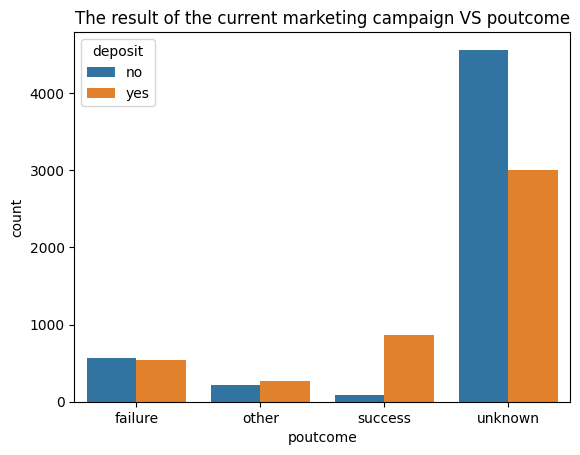

In [18]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
# Группируем данные по результату прошлой кампании и подсчитываем количество значений в каждой группе по признаку deposit
data = cleaned.groupby('poutcome', as_index=False)['deposit'].value_counts()
display(data)

# Строим столбчатую диаграмму по полученным данным
fig = sns.barplot(data=data, x='poutcome', y = 'count', hue='deposit')
fig.set_title('The result of the current marketing campaign VS poutcome');


### *Вывод*

На диаграмме видно, что для статуса предыдущей маркетинговой кампании "success" успех в текущей превалирует над количеством неудач

### Задание 7

,month,deposit,proportion
1,apr,no,0.381928
2,aug,no,0.559567
5,dec,no,0.096774
7,feb,no,0.455571
8,jan,no,0.608150
10,jul,no,0.589563
12,jun,no,0.548913
15,mar,no,0.101266
16,may,no,0.678640
18,nov,no,0.584615


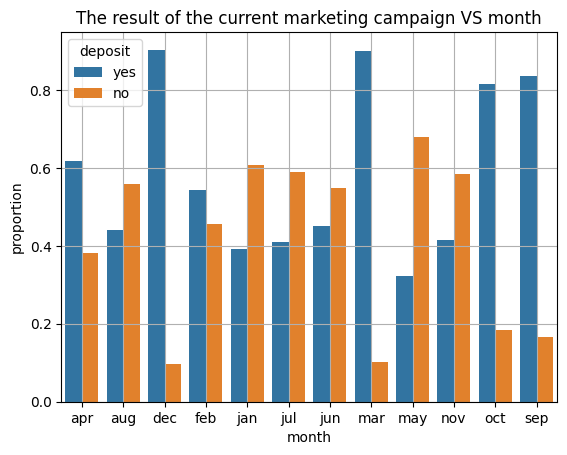

In [19]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
# Сгруппируем данные по признаку month и расчитаем доли значений по признаку deposit
data = cleaned.groupby('month', as_index=False)['deposit'].value_counts(normalize=True)
display(data[data['deposit']=='no'])
# Построим визуализацию
fig = sns.barplot(data=data, x='month', y='proportion', hue='deposit')
fig.set_title('The result of the current marketing campaign VS month')
fig.grid()

### *Вывод*

Диаграмма показывает, что чаще всего отказывались от предложения открыть депозит в мае месяце.


### Задание 8

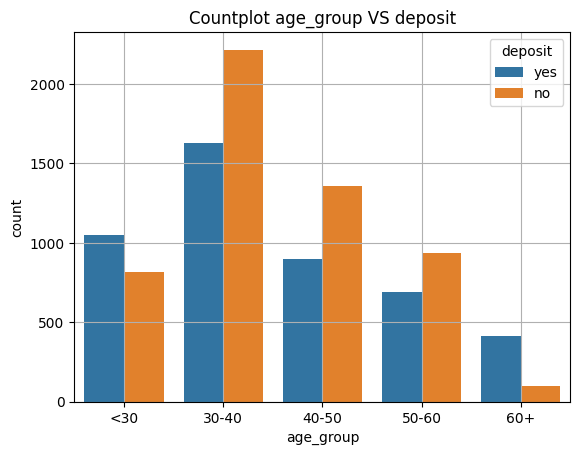

In [20]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения.
# Для разбиения на группы используем метод cut() библиотеки pandas
cleaned['age_group'] = pd.cut(cleaned['age'], bins=[0, 30, 40, 50, 60, 120], labels=['<30', '30-40', '40-50', '50-60', '60+'])

# Строим визуализацию
fig = sns.countplot(data=cleaned, x='age_group', hue='deposit')
fig.set_title('Countplot age_group VS deposit')
fig.grid()

        

### *Вывод*

На диаграмме видно, что клиенты из возрастных групп "<30" и "60+" более склонны открывать депозит, чем отказываться от предложения.


### Задания 9 и 10

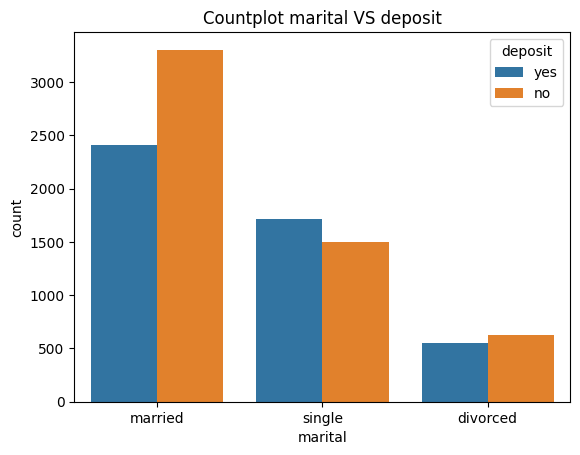

In [21]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
fig = sns.countplot(data=cleaned, x='marital', hue='deposit')
fig.set_title('Countplot marital VS deposit');

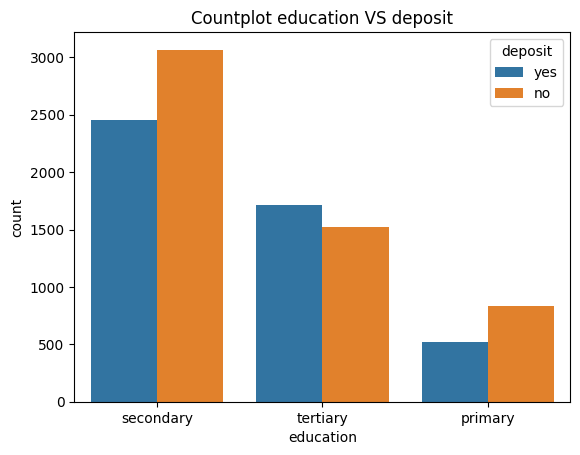

In [22]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования
fig = sns.countplot(data=cleaned, x='education', hue='deposit')
fig.set_title('Countplot education VS deposit');

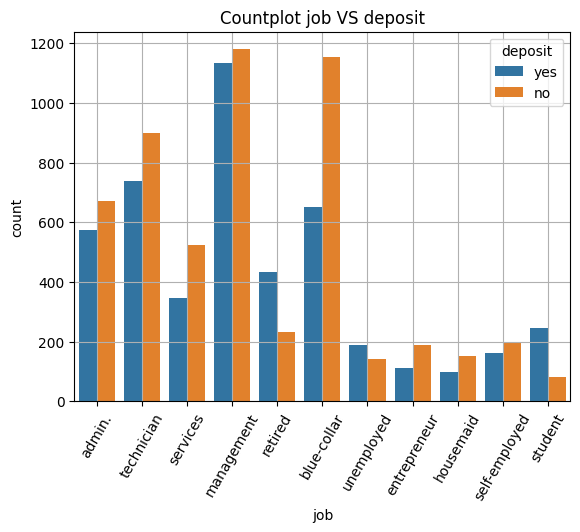

In [23]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
fig = sns.countplot(data=cleaned, x='job', hue='deposit')
fig.xaxis.set_tick_params(rotation=60)
fig.grid()
fig.set_title('Countplot job VS deposit');

### *Вывод*

Из построенных диаграмм видно:
+ наибольшее число клиентов банка занято в сфере менеджмента;
+ чаще открывают депозит, а не отказываются от его открытия клиенты с высшим образованием;
+ чаще открывают депозит, а не отказываются от его открытия одинокие клиенты.

### Задание 11

'Table for deposit status - no'

education,primary,secondary,tertiary
marital,,,
divorced,91,370,163
married,641,1830,832
single,100,866,531


'Table for deposit status - yes'

education,primary,secondary,tertiary
marital,,,
divorced,96,283,174
married,339,1289,784
single,82,879,755


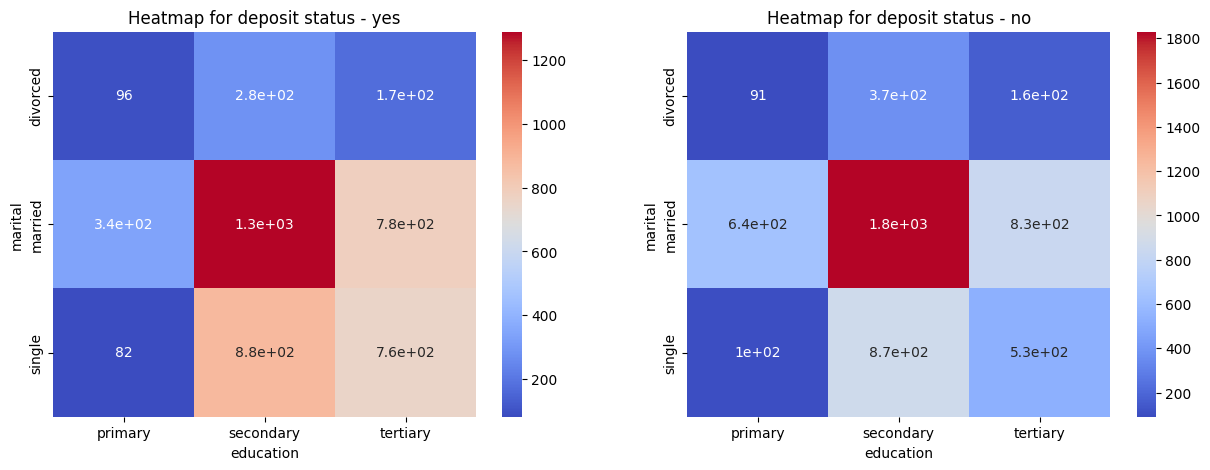

In [24]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)
# Используем метод crosstab библиотеки pandas 
dep_no = pd.crosstab(cleaned.marital, cleaned.education, values=cleaned[cleaned['deposit']=='no'].deposit, aggfunc='count')
dep_yes = pd.crosstab(cleaned.marital, cleaned.education, values=cleaned[cleaned['deposit']=='yes'].deposit, aggfunc='count')
display('Table for deposit status - no', dep_no, 'Table for deposit status - yes', dep_yes)

# Строим тепловые карты для полученных таблиц
fig, ax = plt.subplots(ncols=2, figsize = (15,5))
heatmap_yes_deposit = sns.heatmap(dep_yes, annot=True, ax=ax[0], cmap='coolwarm')
heatmap_no_deposit = sns.heatmap(dep_no, annot=True, ax=ax[1],  cmap='coolwarm')
heatmap_yes_deposit.set_title('Heatmap for deposit status - yes')
heatmap_no_deposit.set_title('Heatmap for deposit status - no');


### *Вывод*
По результатам построения сводных таблиц и тепловых карт можно сделать вывод, что среди тех клиентов которые открыли депозит большинство имеют семью (married) и средний уровень образования (secondary).

## Часть 3: преобразование данных

### Задание 1

In [25]:
# преобразуйте уровни образования
# Создадим копию данных для упрощения работы
df = cleaned.copy()

# Создаем экземпляр калсса кодировщика и преобразуем столбец 'education'
lab_encoder = LabelEncoder()
df['education'] = lab_encoder.fit_transform(df['education'])

# Закодируем по тому же принципу признак age_group
df['age_group'] = lab_encoder.fit_transform(df['age_group'])

# Проверяем результат
display(df.head())
print(f'Сумма значений в новом признаке составляет: {df.education.sum()}')

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,age_group
0,59,admin.,married,1,no,2343.0,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes,2
1,56,admin.,married,1,no,45.0,no,no,unknown,5,may,1467,1,-1,0,unknown,yes,2
2,41,technician,married,1,no,1270.0,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes,1
3,55,services,married,1,no,2476.0,yes,no,unknown,5,may,579,1,-1,0,unknown,yes,2
4,54,admin.,married,2,no,184.0,no,no,unknown,5,may,673,2,-1,0,unknown,yes,2


Сумма значений в новом признаке составляет: 11995


### Задания 2 и 3

In [26]:
# преобразуйте бинарные переменные в представление из нулей и единиц
# Преобразуем бинарную целевую переменную в представление 0 и 1
df['deposit'] = lab_encoder.fit_transform(df['deposit'])
print(f"Стандаотное отклонение признака 'default': {round(df['deposit'].std(), 3)}")

# Сделаем то же самое для других бинарных переменных: 'default', 'housing', 'loan'
df['default'] = lab_encoder.fit_transform(df['default'])
df['housing'] = lab_encoder.fit_transform(df['housing'])
df['loan'] = lab_encoder.fit_transform(df['loan'])

# Проверяем результат
display(df.head())
print(f"Сумма средних значений по признакам 'default', 'housing', 'loan': " 
      f"{round(df['default'].mean() + df['housing'].mean() + df['loan'].mean(), 3)}"
      )

Стандаотное отклонение признака 'default': 0.499


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,age_group
0,59,admin.,married,1,0,2343.0,1,0,unknown,5,may,1042,1,-1,0,unknown,1,2
1,56,admin.,married,1,0,45.0,0,0,unknown,5,may,1467,1,-1,0,unknown,1,2
2,41,technician,married,1,0,1270.0,1,0,unknown,5,may,1389,1,-1,0,unknown,1,1
3,55,services,married,1,0,2476.0,1,0,unknown,5,may,579,1,-1,0,unknown,1,2
4,54,admin.,married,2,0,184.0,0,0,unknown,5,may,673,2,-1,0,unknown,1,2


Сумма средних значений по признакам 'default', 'housing', 'loan': 0.635


### Задание 4

In [27]:
# создайте дамми-переменные
# используем функцию get_dummies библиотеки pandas для кодирования признаков 'job', 'marital', 'contact', 'month', 'poutcome'
dum = pd.get_dummies(df, dtype='int',columns=['job', 'marital', 'contact', 'month', 'poutcome'], drop_first=False)

# Добавляем в датафрейм исходные столбцы
df_dum = pd.concat([dum, df[['job', 'marital', 'contact', 'month', 'poutcome']]], axis=1)

# Проверяем результат
display(df_dum.head())
print(f'Количество признаков без учета целевой переменной: {df_dum.shape[1]-1}')


,age,education,default,balance,housing,loan,day,duration,campaign,pdays,...,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown,job,marital,contact,month,poutcome
0,59,1,0,2343.0,1,0,5,1042,1,-1,...,0,0,0,0,1,admin.,married,unknown,may,unknown
1,56,1,0,45.0,0,0,5,1467,1,-1,...,0,0,0,0,1,admin.,married,unknown,may,unknown
2,41,1,0,1270.0,1,0,5,1389,1,-1,...,0,0,0,0,1,technician,married,unknown,may,unknown
3,55,1,0,2476.0,1,0,5,579,1,-1,...,0,0,0,0,1,services,married,unknown,may,unknown
4,54,2,0,184.0,0,0,5,673,2,-1,...,0,0,0,0,1,admin.,married,unknown,may,unknown


Количество признаков без учета целевой переменной: 50


### Задания 5 и 6

Степень корреляции с целевой переменной признаков 'poutcome_success', 'duration','contact_cellular':


duration            0.457818
poutcome_success    0.288491
contact_cellular    0.223944
Name: deposit, dtype: float64

В данных отсутствует мультиколлинеарность


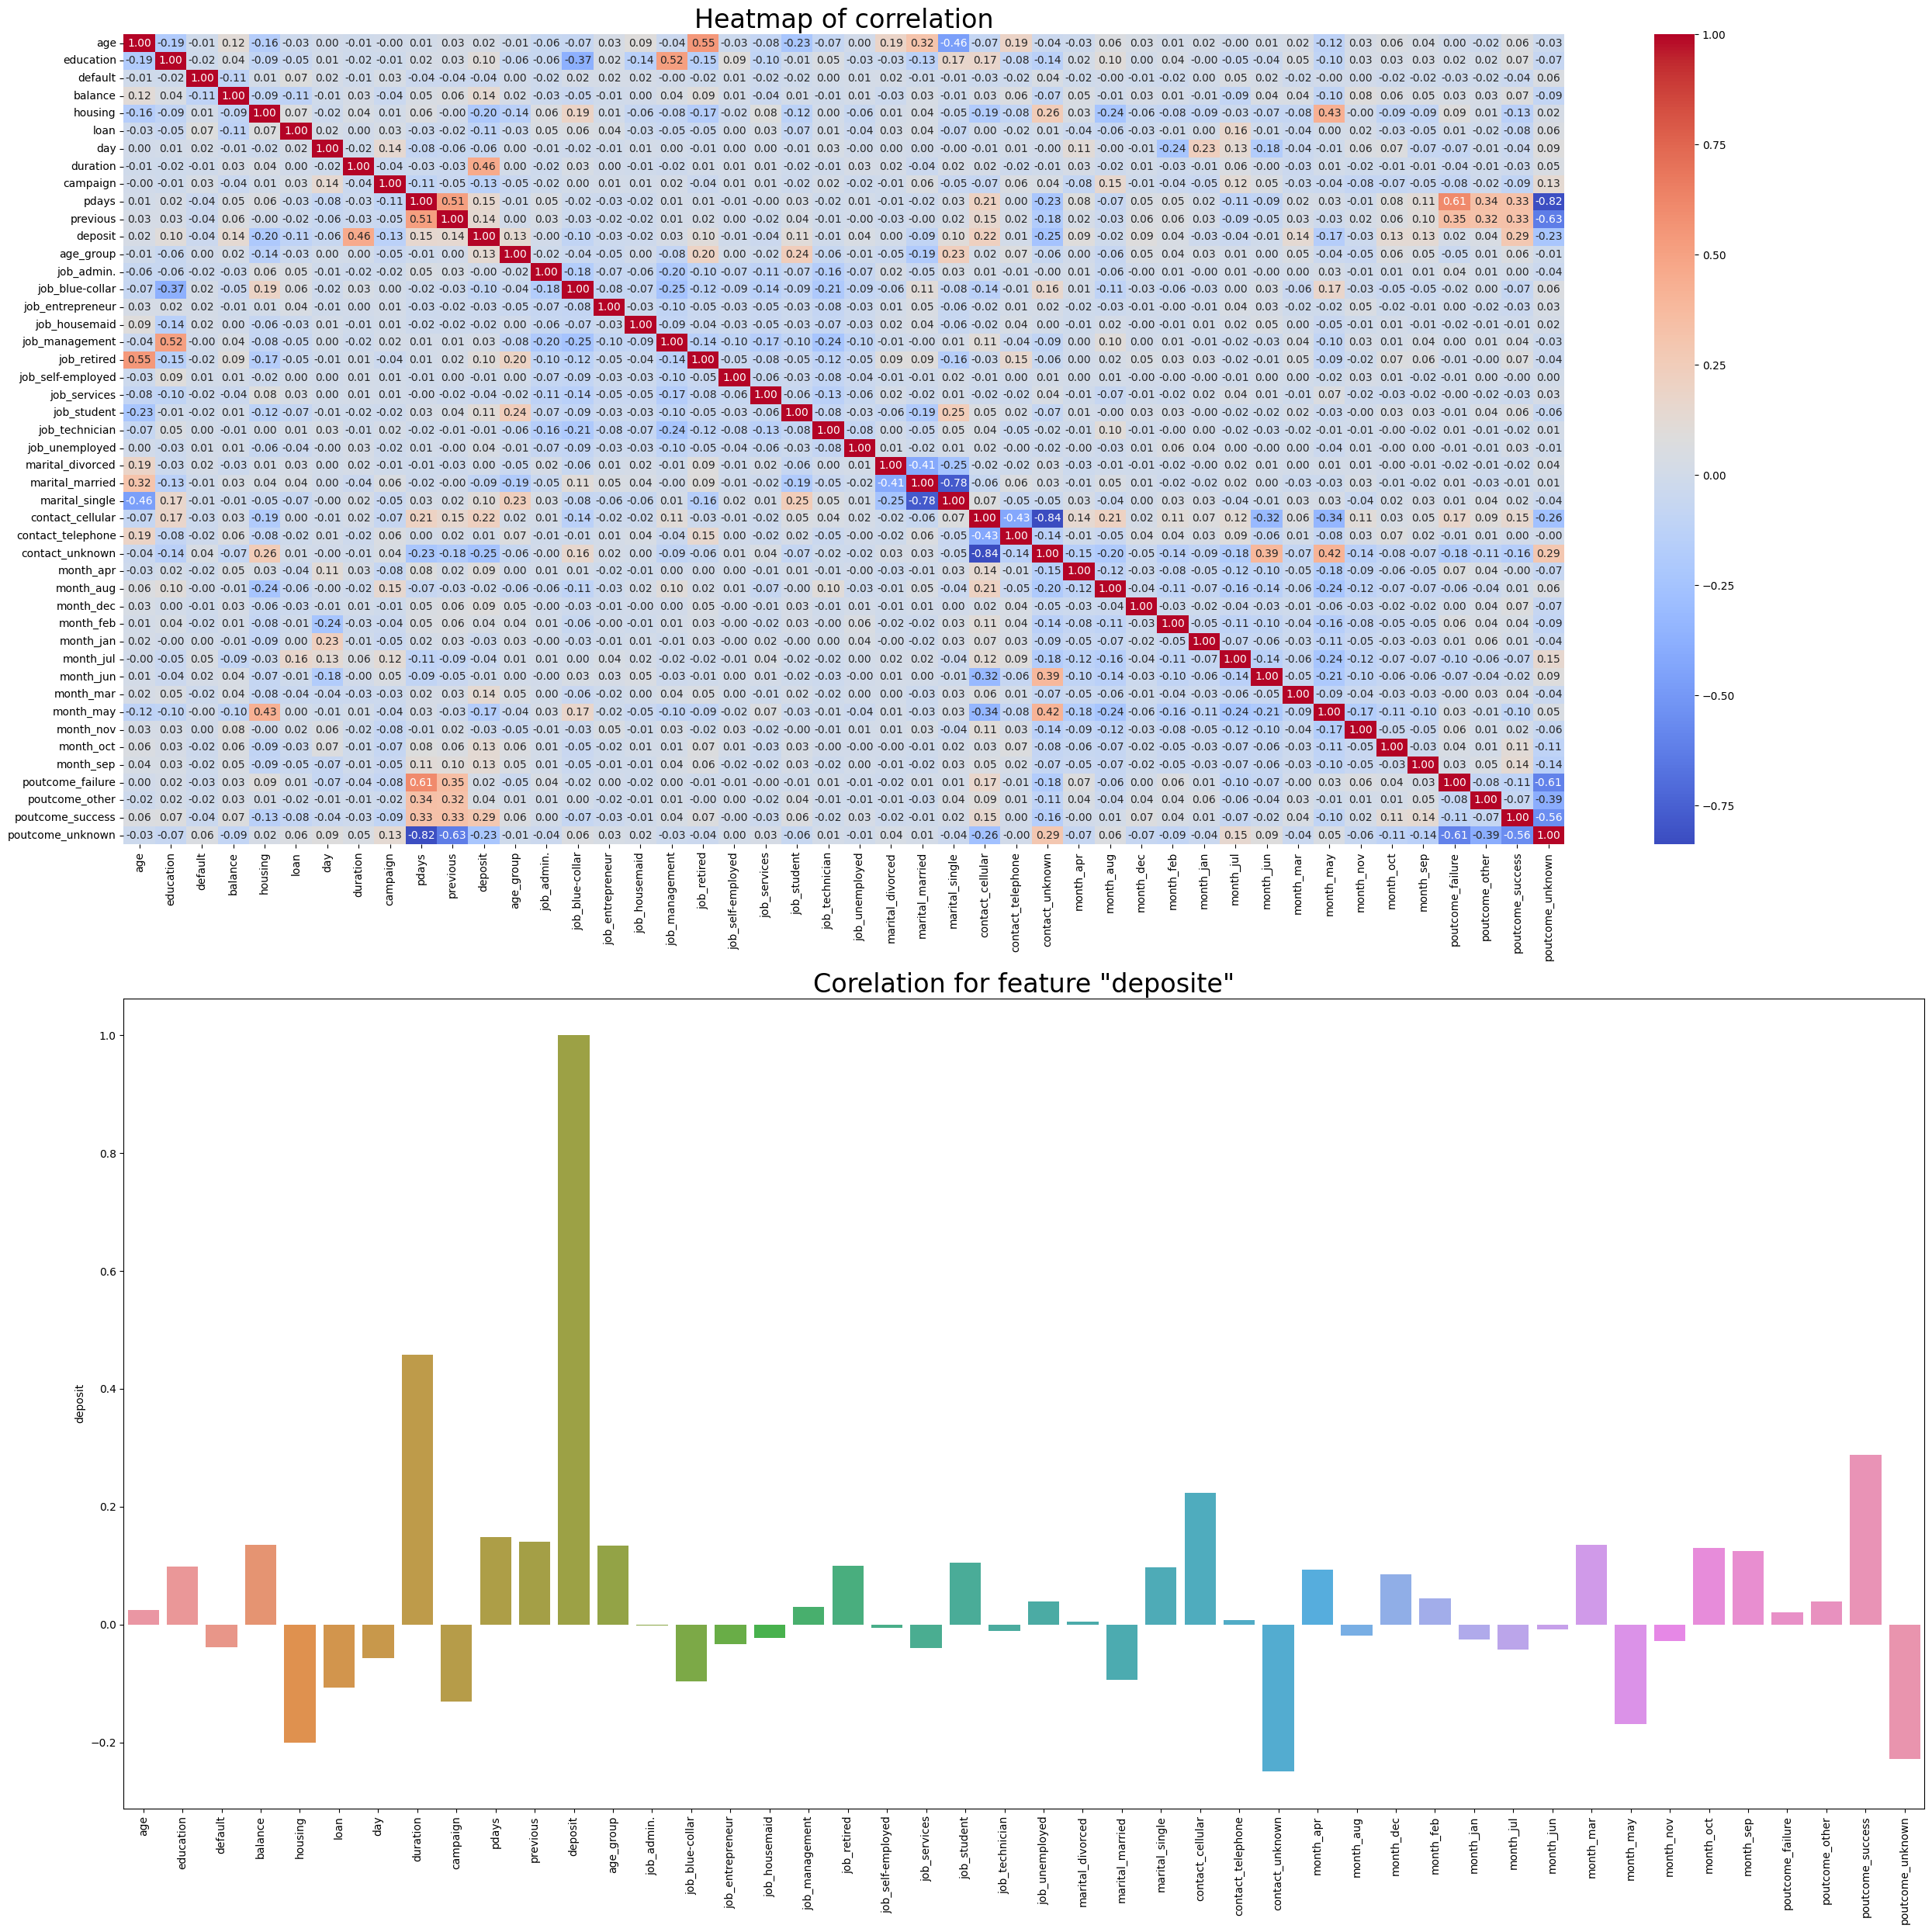

In [28]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности
# создаем матрицу корреляции
corr = df_dum.corr(numeric_only=True)

# создаем тепловую карту для визуализации матрицы корреляции
fig, ax = plt.subplots(nrows=2, figsize=(25,25))
heatmap = sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', ax=ax[0])
heatmap.set_title('Heatmap of correlation',  fontsize=24)

# создаем столбчатую диаграмму для визуализации корреляции с признаком 'deposit'
barplot = sns.barplot(x=corr.index, y=corr['deposit'], ax=ax[1])
barplot.set_title('Corelation for feature "deposite"', fontsize=24)
barplot.xaxis.set_tick_params(rotation=90)

# выравнивание графиков
plt.tight_layout()

print("Степень корреляции с целевой переменной признаков 'poutcome_success', 'duration','contact_cellular':")
display(corr.loc[['poutcome_success', 'duration','contact_cellular'] ,'deposit'].sort_values(ascending=False))

# Выведем признаки для которых сила корреляциии не менее 0.9
ls_p = list() # создаем пустой список

# В цикле перебираем все названия столбцов матрицы корреляции, 
# при выполнении условия, что значение текущего признака в строке 'deposit' не менее 0.9 
# и признак не является целевым добавляем в список ls_p список с наименованием признаков и силой корреляции
for i in corr.columns:
    if (corr['deposit'].loc[i] >= 0.9) & (i != 'deposit'):
        ls_p.append(['deposit', i, str(round(corr['deposit'].loc[i], 2))])
        
# Если список пуст делаем вывод об отсутствии мультиколлинеарности в данных
if len(ls_p):
    print('В данных есть мультиколлинеарность. Список признаков с корреляцией не менее 0.9: ', ls_p)
else:
    print('В данных отсутствует мультиколлинеарность')  

### Задания 7 и 8

In [29]:
X = df_dum.drop(['deposit'], axis=1)
y = df_dum['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [30]:
# рассчитайте необходимые показатели
print(f'Количество строк в тестовой выборки: {X_test.shape[0]}')
print(f'Среднее значение целевой переменной на тестовой выборке: {round(y_test.mean(), 2)}')

Количество строк в тестовой выборки: 3335
Среднее значение целевой переменной на тестовой выборке: 0.46


### Задание 9

In [31]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков
# создадим список числовых признаков, отсортировав по типу данных 
# используем тильду для инверсии условия фильтрации
types = X_train.dtypes
num_features = list(types[~(types == 'object')].index)

# Проведем отбор 15 признаков с помощью SelectKBest на обучающей выборке
selector = SelectKBest(score_func=f_classif, k=15)
selector.fit(X_train[num_features], y_train)

# Сохраним отобранные признаки в отдельной переменной 
best_feature = selector.get_feature_names_out()

# Проверим наличие признаков 'month_mar', 'month_may', 'month_oct', 'month_sep', 'month_jan' среди отобранных
ls = ['month_mar', 'month_may', 'month_oct', 'month_sep', 'month_jan']
for i in ls:
    if i in best_feature:
        continue
    else:
        print(f'Среди отобранных признаков отсутствует признак: {i}') 

Среди отобранных признаков отсутствует признак: month_jan


### Задание 10

In [32]:
# нормализуйте данные с помощью minmaxsxaler
mm_scaler = preprocessing.MinMaxScaler()
mm_scaler.fit(X_train[best_feature])
X_train_mm = mm_scaler.transform(X_train[best_feature])
X_test_mm = mm_scaler.transform(X_test[best_feature])

# Выведем среднее арифметическое для первого предиктора (т. е. для первого столбца матрицы) из тестовой выборки
print(f'Cреднее арифметическое для первого предиктора из тестовой выборки: {round(X_test_mm[:,0].mean(),2)}')

Cреднее арифметическое для первого предиктора из тестовой выборки: 0.47


# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [33]:
# обучите логистическую регрессию и рассчитайте метрики качества
log_reg = linear_model.LogisticRegression(solver='sag', random_state=42, max_iter=1000)
log_reg.fit(X_train_mm, y_train)
pred_test = log_reg.predict(X_test_mm)

# выводим значение метрики accuracy на тестовой выборке
print(f'Значение метрики accuracy на тестовой выборке: {round(metrics.accuracy_score(y_true=y_test, y_pred=pred_test), 2)}')

Значение метрики accuracy на тестовой выборке: 0.81


### Задания 2,3,4

Значение метрики accuracy на обучающей выборке: 0.78
Значение метрики accuracy на тестовой выборке: 0.77


Наибольшее значение accuracy: 0.81
Максимальная глубина дерева: 6


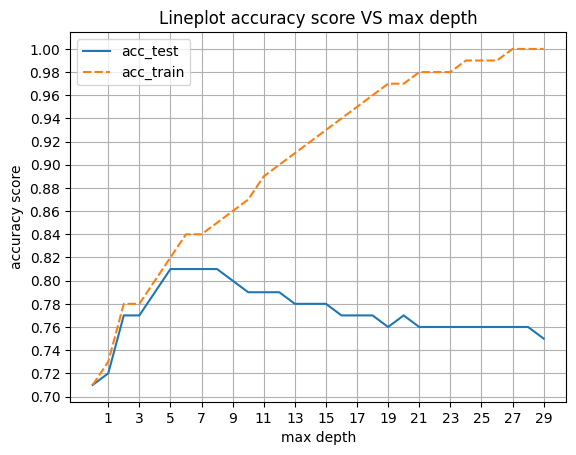

In [34]:
# обучите решающие деревья, настройте максимальную глубину
d_tree = tree.DecisionTreeClassifier(criterion = 'entropy', random_state = 42, max_depth=4)
d_tree.fit(X_train_mm, y_train)
pred_test = d_tree.predict(X_test_mm)
pred_train = d_tree.predict(X_train_mm)

# выводим значение метрики accuracy на тестовой выборке
print(f'Значение метрики accuracy на обучающей выборке: {round(metrics.accuracy_score(y_true=y_train, y_pred=pred_train), 2)}')
print(f'Значение метрики accuracy на тестовой выборке: {round(metrics.accuracy_score(y_true=y_test, y_pred=pred_test), 2)}')

# Создаем списки для фиксации результатов подбора параметров
acc_test = []
acc_train = []
max_depth = []

# Перебираем в цикле максимальную глубину дерева решений и фиксируем метрики в списки
for i in range(1, 31):
    d_tree = tree.DecisionTreeClassifier(criterion = 'entropy', random_state = 42, max_depth=i)
    d_tree.fit(X_train_mm, y_train)
    pred_test = d_tree.predict(X_test_mm)
    pred_train = d_tree.predict(X_train_mm)
    acc_test.append(round(metrics.accuracy_score(y_true=y_test, y_pred=pred_test), 2))
    acc_train.append(round(metrics.accuracy_score(y_true=y_train, y_pred=pred_train), 2))
    max_depth.append(i)

# Создаем датафрейм и визуализируем результаты
dat = pd.DataFrame({'acc_test':acc_test, 'acc_train':acc_train, 'max_depth':max_depth})
fig = sns.lineplot(dat[['acc_test', 'acc_train']], legend='full')
fig.set_xticks(ticks=(list(range(1,31, 2))))
fig.set_yticks(ticks=(list(np.arange(0.7, 1.0, 0.02))))
fig.set_ylabel('accuracy score')
fig.set_xlabel('max depth')
fig.set_title('Lineplot accuracy score VS max depth')
fig.grid()

# Выводим лучшее значение метрики и соответствующее ему значение max_depth
print(f'Наибольшее значение accuracy: {max(acc_test)}')
print(f'Максимальная глубина дерева: {max_depth[acc_test.index(max(acc_test))] }') 

### Задание 5

In [35]:
# подберите оптимальные параметры с помощью gridsearch
# Задаем сетку параметров
param = {'min_samples_split': [2, 5, 7, 10],
         'max_depth':[3,5,7]
         }

# Создаем объект класса GridSearchCV
grid_search = GridSearchCV(estimator=tree.DecisionTreeClassifier(criterion='entropy', random_state=42),
                           param_grid=param,                               
                           n_jobs=-1
                           )

# Производим подбор гиперпараметров
grid_search.fit(X_train_mm, y_train)

# Делаем предсказание
y_test_pred = grid_search.predict(X_test_mm)

# Выведем лучшую комбинацию гиперпараметров и значение метрики на тестовой выборке
print(f'Лучшая комбинация гиперпараметров: {grid_search.best_params_}')
print(f'Значение метрики f1-score на тестовой выборке для модели случайного леса: {round(metrics.f1_score(y_test, y_test_pred),2)}')

Лучшая комбинация гиперпараметров: {'max_depth': 7, 'min_samples_split': 10}
Значение метрики f1-score на тестовой выборке для модели случайного леса: 0.8


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [36]:
# обучите на ваших данных случайный лес
rf_classif = ensemble.RandomForestClassifier(n_estimators = 100,
                                             criterion = 'gini',
                                             min_samples_leaf = 5,
                                             max_depth = 10,
                                             random_state = 42
                                             )

# Обучаем модель, делаем предсказание и выводим метрики
rf_classif.fit(X_train_mm, y_train)
y_pred = rf_classif.predict(X_test_mm)
print(f'Значение метрики accuracy на тестовой выборке: {round(metrics.accuracy_score(y_test, y_pred), 2)}')
print(f'Значение метрики recall на тестовой выборке: {round(metrics.recall_score(y_test, y_pred), 2)}')

Значение метрики accuracy на тестовой выборке: 0.83
Значение метрики recall на тестовой выборке: 0.83


### Задания 2 и 3

In [37]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом
gb_classif = ensemble.GradientBoostingClassifier(learning_rate = 0.05,
                                                 n_estimators = 300,
                                                 min_samples_leaf = 5,
                                                 max_depth = 5,
                                                 random_state = 42
                                                 )

# Обучаем модель, делаем предсказание и выводим метрики
gb_classif.fit(X_train_mm, y_train)
y_pred_gb = gb_classif.predict(X_test_mm)
print(f'Значение метрики accuracy на тестовой выборке: {round(metrics.accuracy_score(y_test, y_pred_gb), 2)}')
print(f'Значение метрики recall на тестовой выборке: {round(metrics.recall_score(y_test, y_pred_gb), 2)}')
print(f'Значение метрики f1 score на тестовой выборке: {round(metrics.f1_score(y_test, y_pred_gb), 2)}')

Значение метрики accuracy на тестовой выборке: 0.83
Значение метрики recall на тестовой выборке: 0.83
Значение метрики f1 score на тестовой выборке: 0.82


### Задание 4

In [38]:
# объедините уже известные вам алгоритмы с помощью стекинга
# Создаем список кортежей вида: (наименование модели, модель):
estimators=[('dt', tree.DecisionTreeClassifier(criterion='entropy',
                                               random_state=42,
                                               max_depth=6,                                               
                                               min_samples_split=10
                                               )
             ),
            ('lr', linear_model.LogisticRegression(solver='sag',
                                                   random_state=42,
                                                   max_iter=1000
                                                   )
             ), 
            ('gb', ensemble.GradientBoostingClassifier(learning_rate = 0.05,
                                                       n_estimators = 300,
                                                       min_samples_leaf = 5,
                                                       max_depth = 5,
                                                       random_state = 42
                                                       )
             )
            ] 

# Задаем модель стэкинга
stack_classif = ensemble.StackingClassifier(estimators=estimators,
                                            final_estimator=linear_model.LogisticRegression(random_state=42)
                                            )

# Обучаем модель, делаем предсказание и выводим метрики
stack_classif.fit(X_train_mm, y_train)
y_pred_st = stack_classif.predict(X_test_mm)
print(f'Значение метрики precision на тестовой выборке: {round(metrics.precision_score(y_test, y_pred_st), 2)}')



Значение метрики precision на тестовой выборке: 0.81


### Задание 5

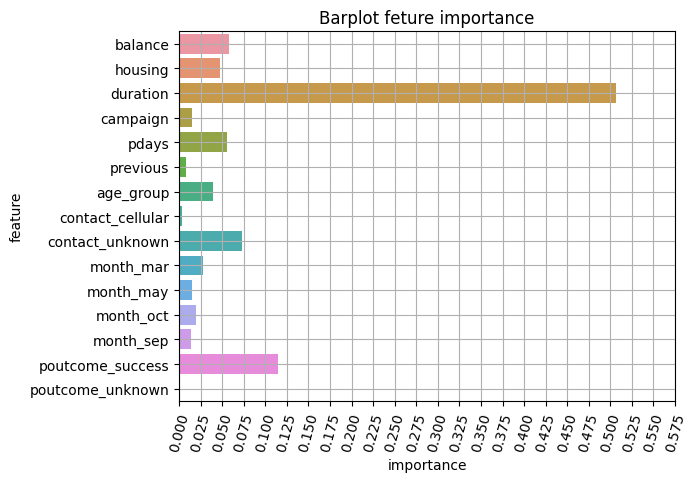

In [39]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга
importance = gb_classif.feature_importances_

# Визуализируем значимость признаков с помощью столбчатой диаграммы
fig = sns.barplot(y=best_feature, x=importance)
fig.set_yticks(ticks=(list(range(0,15, 1))))
fig.set_xticks(ticks=(list(np.arange(0.0, 0.6, 0.025))))
fig.set_xlabel('importance')
fig.set_ylabel('feature')
fig.set_title('Barplot feture importance')
fig.grid()
fig.xaxis.set_tick_params(rotation=75)

In [40]:
# Проведем отбор 3 важных признаков с помощью метода рекурсивного исключения признаков
selector_rfe = RFE(estimator=ensemble.GradientBoostingClassifier(learning_rate = 0.05,
                                                                 n_estimators = 300,
                                                                 min_samples_leaf = 5,
                                                                 max_depth = 5,
                                                                 random_state = 42                                                                 
                                                                 ),
                   n_features_to_select=3,
                   step=1
                   )

# Обучаем селектор
selector_rfe.fit(X_train_mm, y_train)

# Выведем 3 наиболее значимых признака по методу RFE
best_3_rfe = selector_rfe.get_feature_names_out()
print(best_3_rfe)
print('\n', best_feature[0], '\n', best_feature[2], '\n', best_feature[13])

['x0' 'x2' 'x13']

 balance 
 duration 
 poutcome_success


### *Вывод*
Наибольшую значимость для модели градиентного бустинга имеют признаки 'duration', 'contact_unknown', 'poutcome_success'. Эти признаки имеют наибольшую  корреляцию с целевым признаком  0.46, минус 0.25 и 0.29 соответственно. При отборе наиболее важных признаков по методу RFE вместо признака 'contact_unknown' был отобран признак 'balance'.

### Задания 6,7,8

In [45]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna
# Задаем функцию оптимизации для моедли случайного леса
def optuna_rf(trial):
    # задаем пространства поиска гиперпараметров
    n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
    max_depth = trial.suggest_int('max_depth', 10, 30, 1)   
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)
    
    # создаем модель
    model = ensemble.RandomForestClassifier(n_estimators=n_estimators,                                            
                                            min_samples_leaf=min_samples_leaf,
                                            max_depth=max_depth,
                                            random_state=42)
    # обучаем модель с кросс-валидацией 
    # score = cross_val_score(model, X_train_mm, y_train, cv=5, scoring='f1', n_jobs=-1).mean()
    
    # обучаем модель и считаем метрику 
    model.fit(X_train_mm, y_train)
    score = metrics.f1_score(y_train, model.predict(X_train_mm))
    return score

# cоздаем объект исследования
opt_rf = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")

# ищем лучшую комбинацию гиперпараметров n_trials раз
opt_rf.optimize(optuna_rf, n_trials=50)

# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(opt_rf.best_params))

# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**opt_rf.best_params, random_state=42)
model.fit(X_train_mm, y_train)

# делаем предсказание и рассчитываем метрику
y_test_pred_rf_opt = model.predict(X_test_mm)
print('f1_score на тестовом наборе для модели случайного леса: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred_rf_opt)))
print('accuracy на тестовом наборе для модели случайного леса: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred_rf_opt)))

[I 2023-07-09 17:00:02,752] A new study created in memory with name: RandomForestClassifier
[I 2023-07-09 17:00:03,209] Trial 0 finished with value: 0.8571428571428571 and parameters: {'n_estimators': 134, 'max_depth': 12, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.8571428571428571.
[I 2023-07-09 17:00:03,600] Trial 1 finished with value: 0.8440800882862999 and parameters: {'n_estimators': 122, 'max_depth': 18, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.8571428571428571.
[I 2023-07-09 17:00:04,082] Trial 2 finished with value: 0.8450925054876137 and parameters: {'n_estimators': 150, 'max_depth': 27, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.8571428571428571.
[I 2023-07-09 17:00:04,742] Trial 3 finished with value: 0.8580314103560877 and parameters: {'n_estimators': 193, 'max_depth': 23, 'min_samples_leaf': 7}. Best is trial 3 with value: 0.8580314103560877.
[I 2023-07-09 17:00:05,389] Trial 4 finished with value: 0.8540202966432473 and parameters: {'

Наилучшие значения гиперпараметров {'n_estimators': 157, 'max_depth': 28, 'min_samples_leaf': 2}
f1_score на тестовом наборе для модели случайного леса: 0.82
accuracy на тестовом наборе для модели случайного леса: 0.83
